# Fully Bayesian GP Regression

Testing fully Bayesian GP using Pyro for estimating uncertainties in model hyper-parameters.

In [1]:
import numpy as np
import pandas as pd

import sklearn.preprocessing as skl_prep
from statsmodels.nonparametric import smoothers_lowess as sl

# Pytorch + GP
import torch, gpytorch

from pathlib import Path
from rich import print
from tqdm import tqdm

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": False,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

cp = sns.color_palette()

In [21]:
# CUDA setup
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    raise Exception("This notebook requires CUDA")

Exception: This notebook requires CUDA

In [5]:
p = Path('../pq/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [7]:
y = df.slope.to_numpy()
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x[:700], dtype=torch.double)
y_tr = torch.tensor(y[:700], dtype=torch.double)

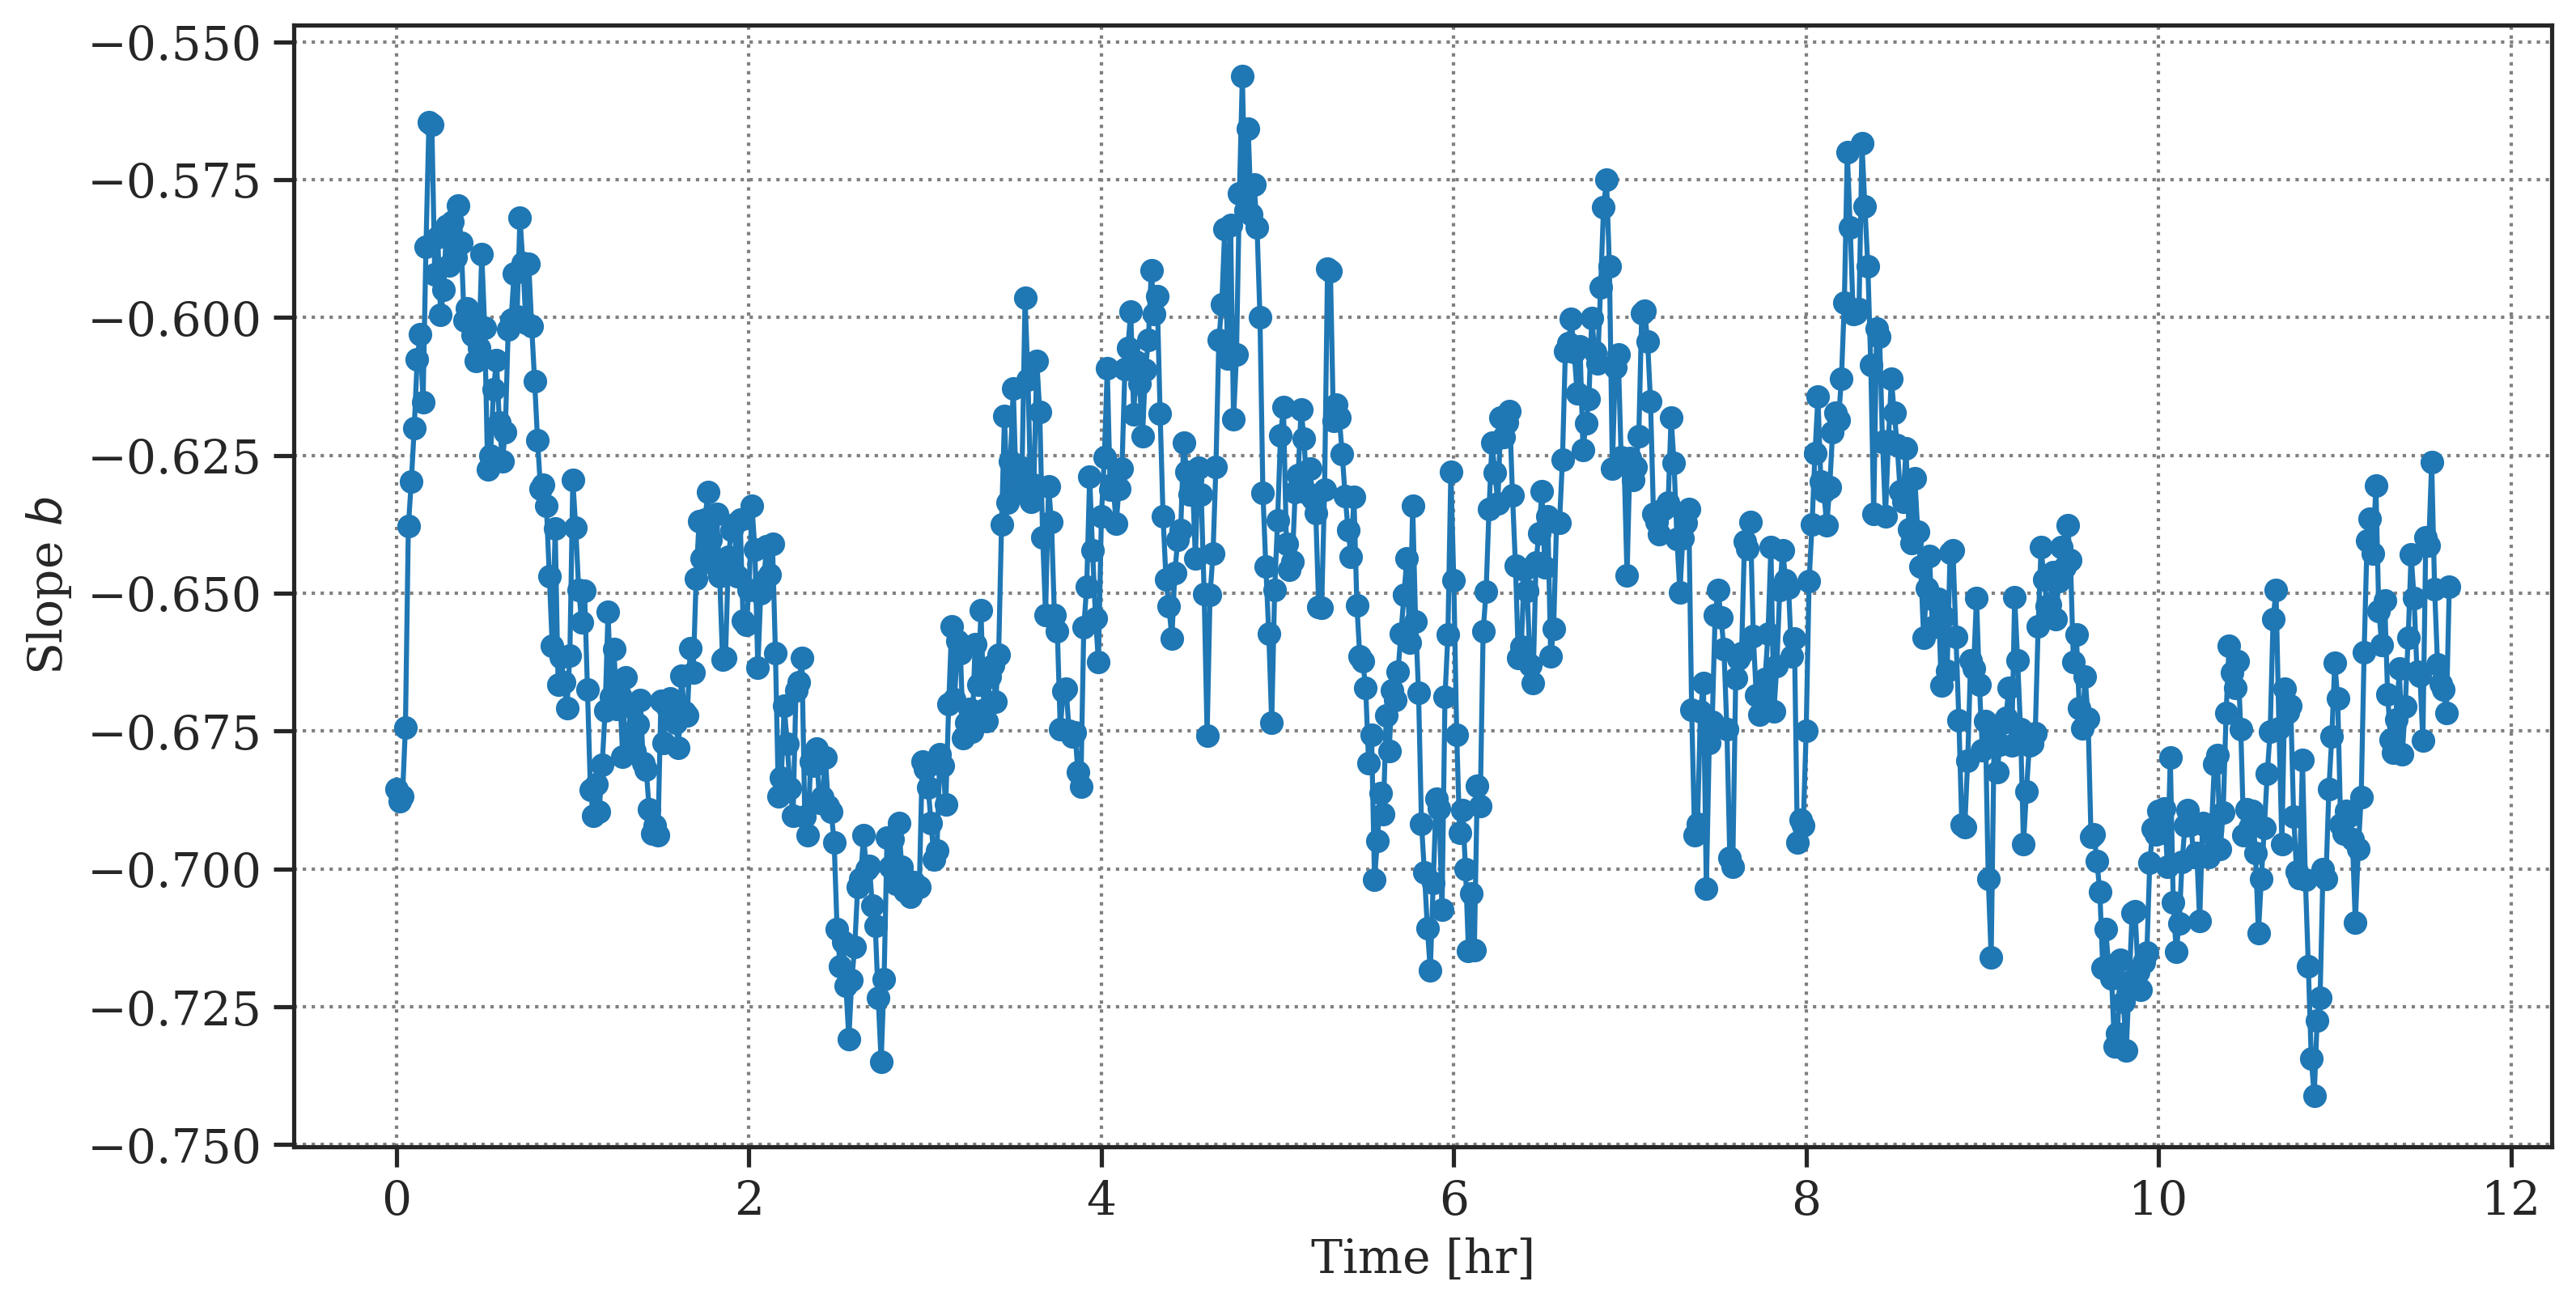

In [8]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x_tr / 60, y_tr, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

In [9]:
if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

In [10]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [11]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-2),
    noise_prior = gpytorch.priors.NormalPrior(1.e-2, 1)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(30.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(30.),
    period_length = torch.tensor(90.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [12]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)
    
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 200
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

 11/200 Loss: 0.406:   5%|▌         | 10/200 [00:00<00:10, 18.62it/s]

200/200 Loss: -1.318: 100%|██████████| 200/200 [00:10<00:00, 19.68it/s]


In [13]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise                 -8.133929658741103

mean_module.raw_constant                         -0.6547890402522433

cov_module.kernels.0.raw_outputscale             -7.610960711186554

cov_module.kernels.0.base_kernel.raw_lengthscale         36.936023193562576

cov_module.kernels.1.raw_outputscale             -6.494507295472733

cov_module.kernels.1.base_kernel.raw_lengthscale         22.893557229802255

cov_module.kernels.1.base_kernel.raw_period_length       95.58484844411694

 The learning rate looks good. It may be a bit too fast (only 200 epochs), but a slower learning rate does not improve the result.

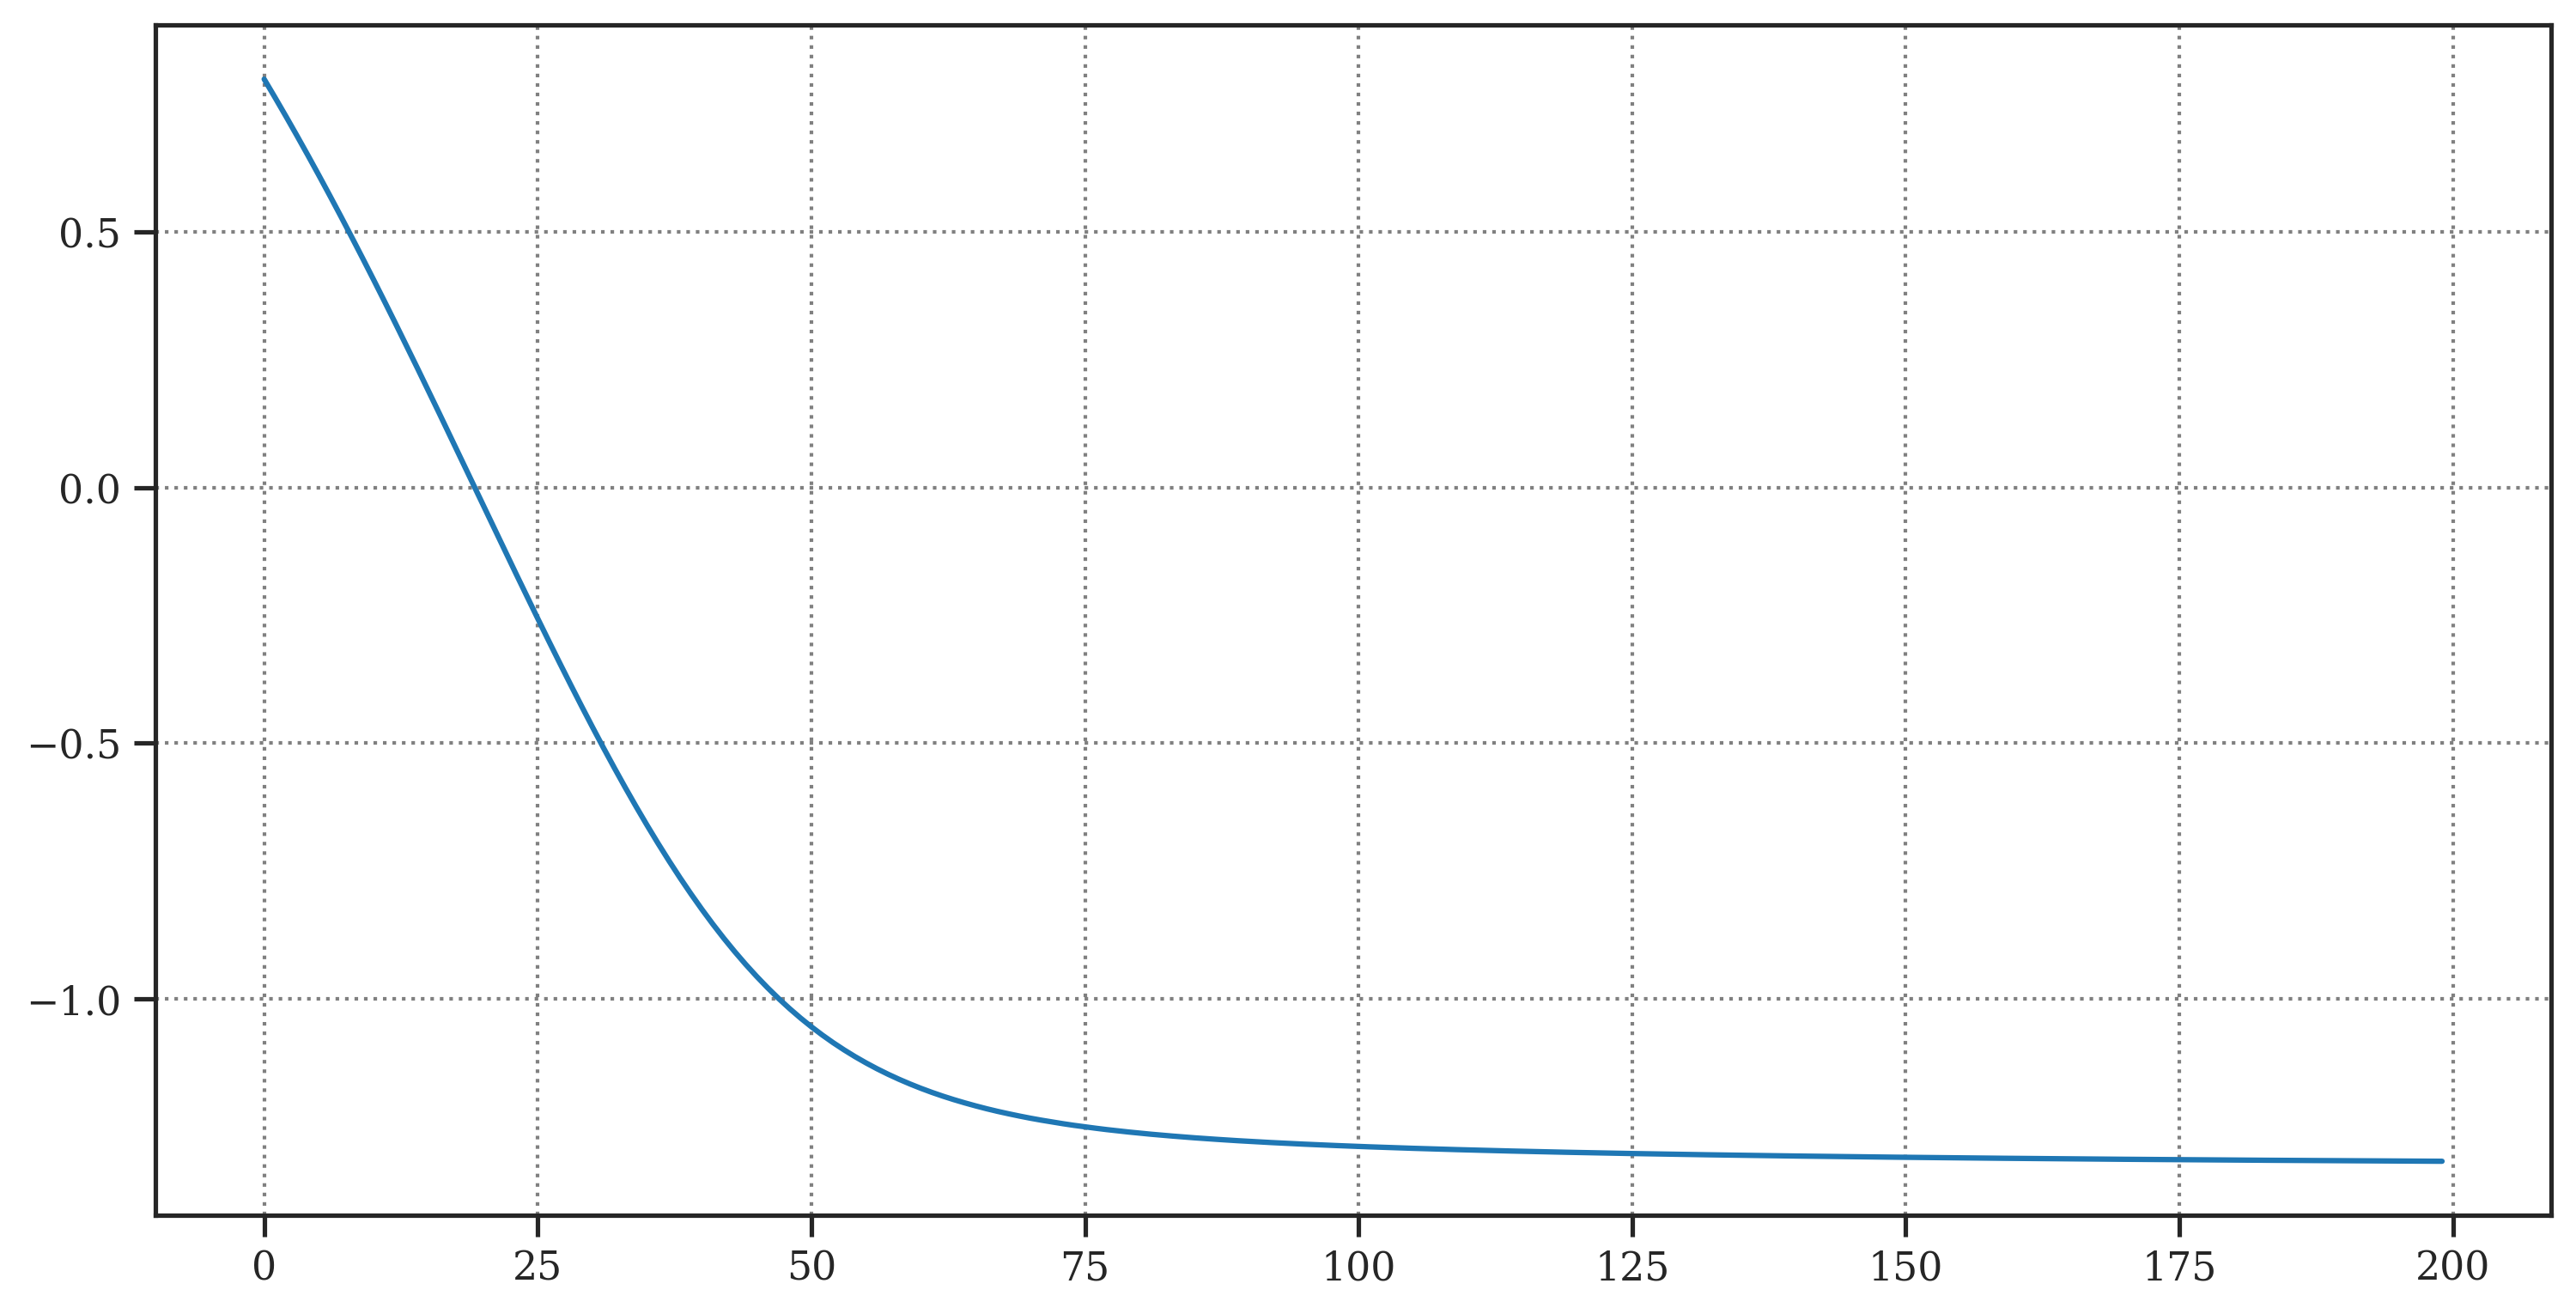

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [15]:
dt = 90

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

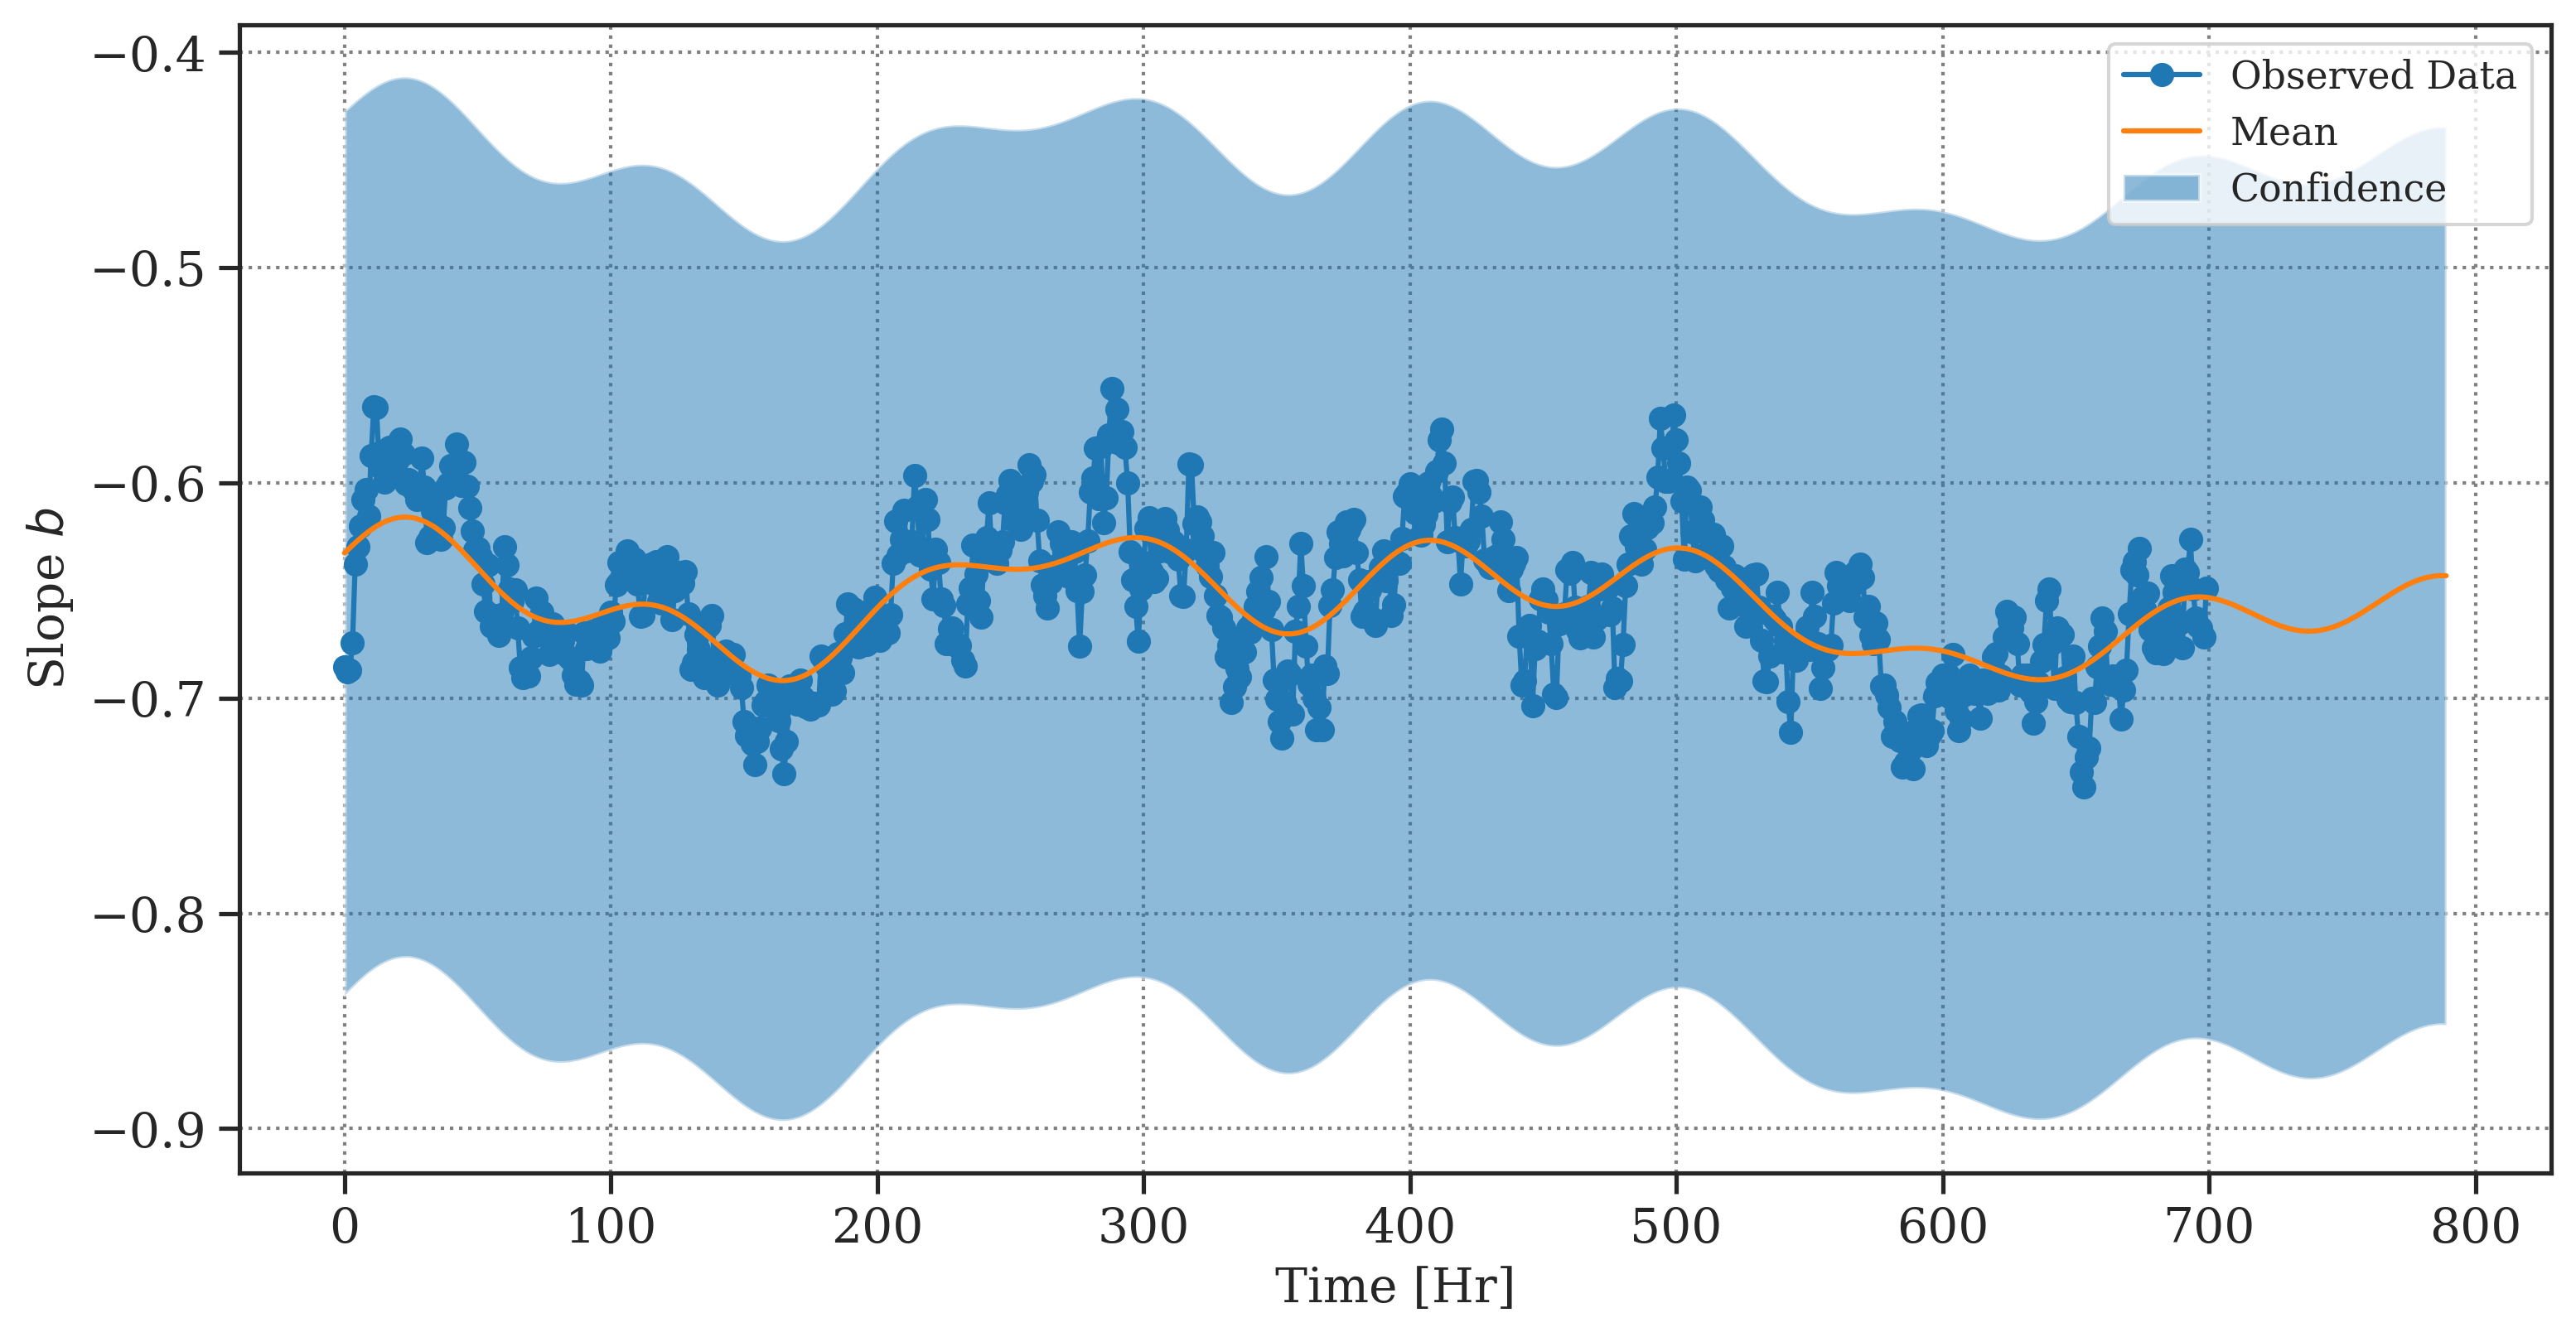

In [16]:
if device.type == 'cuda':
    model = model.cpu()
    likelihood = likelihood.cpu()

    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr, y_tr, 'o-')
ax.plot(x_test, y_mean)
ax.fill_between(x_test, lower, upper, alpha=0.5)

ax.legend(['Observed Data', 'Mean', 'Confidence'])

ax.set_xlabel("Time [Hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

 It may look like I am being too aggressive with the smoothing, but that's because of the long-term trend in the timeseries and the uncertainty is higher because of it. Of course, I want to remain faithful to the (albeit noisy) data. Reducing the length scales for the two kernels definitely help achieve a much better fit, but it is easy to overfit the dataset while not improving the quality of the regression (and especially the periodicity estimation). Overfitting is definitely more harmful than noise.

 The hyperparameters used aren't meant to be accurate, as they are driven by noisy data. The goal here is to smooth out the noise and local variations to obtain a more general trend. 
 
 At times, depending on the data, GP regression will pick up a long-term trend (e.g. over 2-3 hours). In that case, we will have to repeat the regression until no periodic motions can be observed. For the slope of cloud size distribution, fortunately for me, it is not needed.

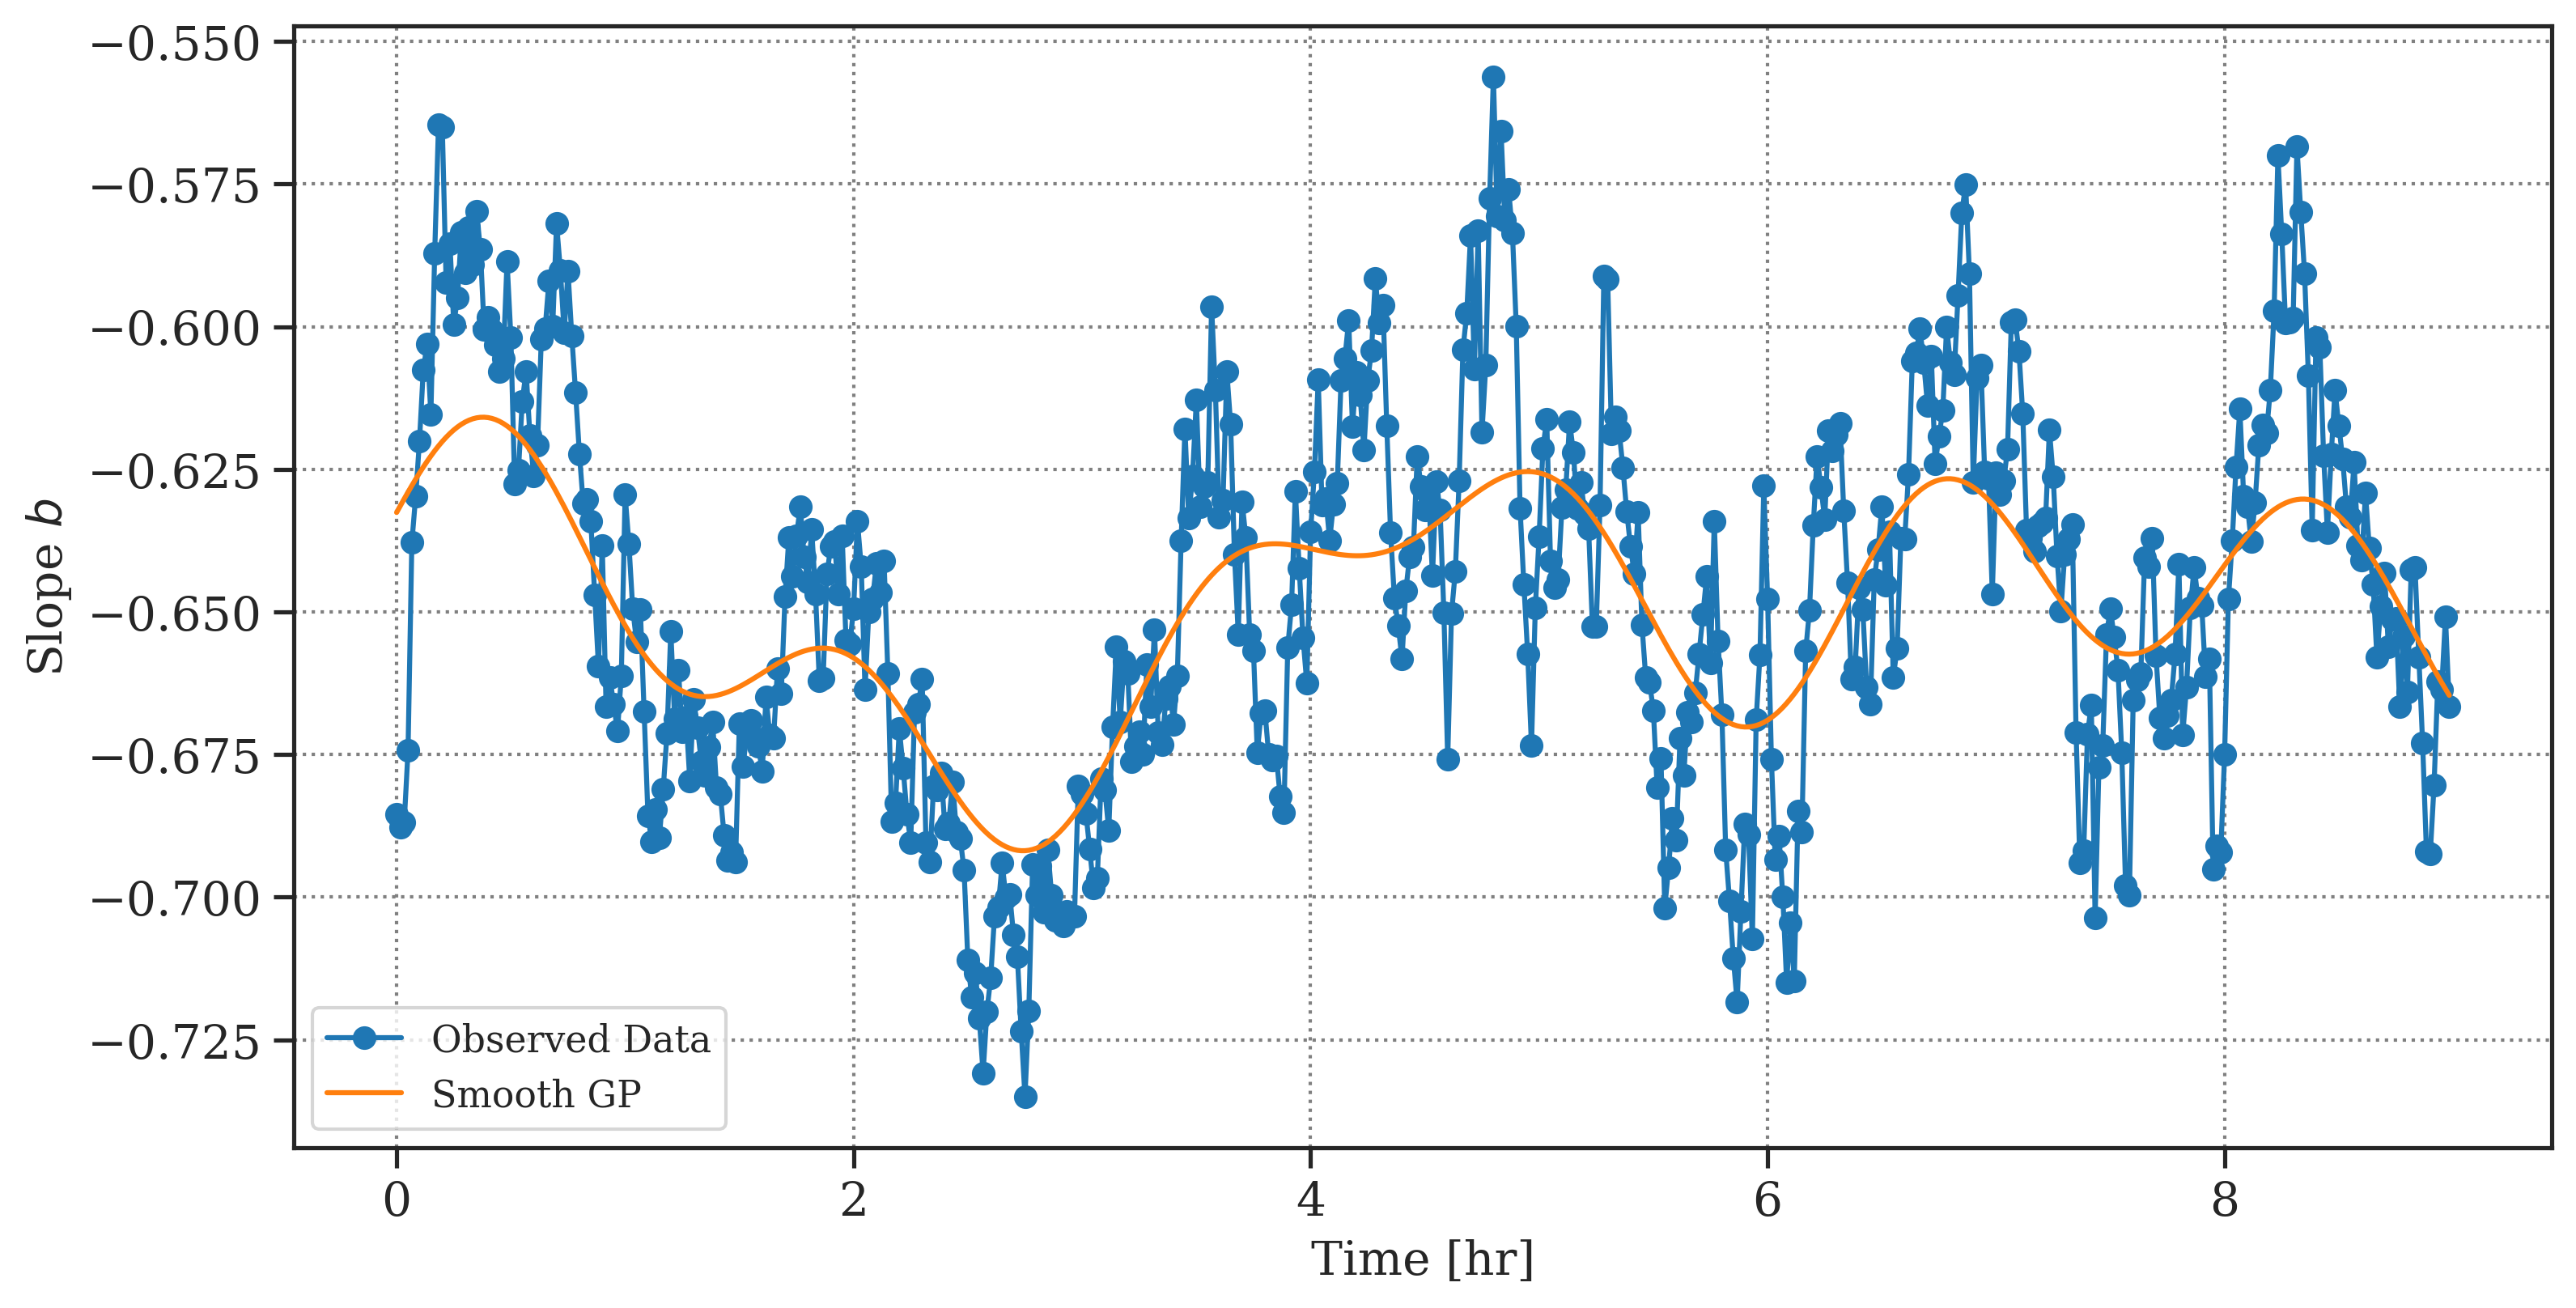

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_full[:540] / 60, y_full[:540], 'o-')
ax.plot(x_test[:540] / 60, y_mean[:540])

ax.legend(['Observed Data', 'Smooth GP'])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

 What do we do with the smooth regression? I used an RBF kernel because it is infinitely differentiable, which is useful. There are a lot of different ways to make a timeseries suitable for regression, but here I find a simply differentiation very powerful in isolating the periodic motion in the timeseries. This also makes the average roughly zero, across, which means that this periodic motion is independent of the general, long-term downward trend seen above. This has an added benefit of making the GP regression much easier, since the only parameter we need to worry about at this point is the periodicity.

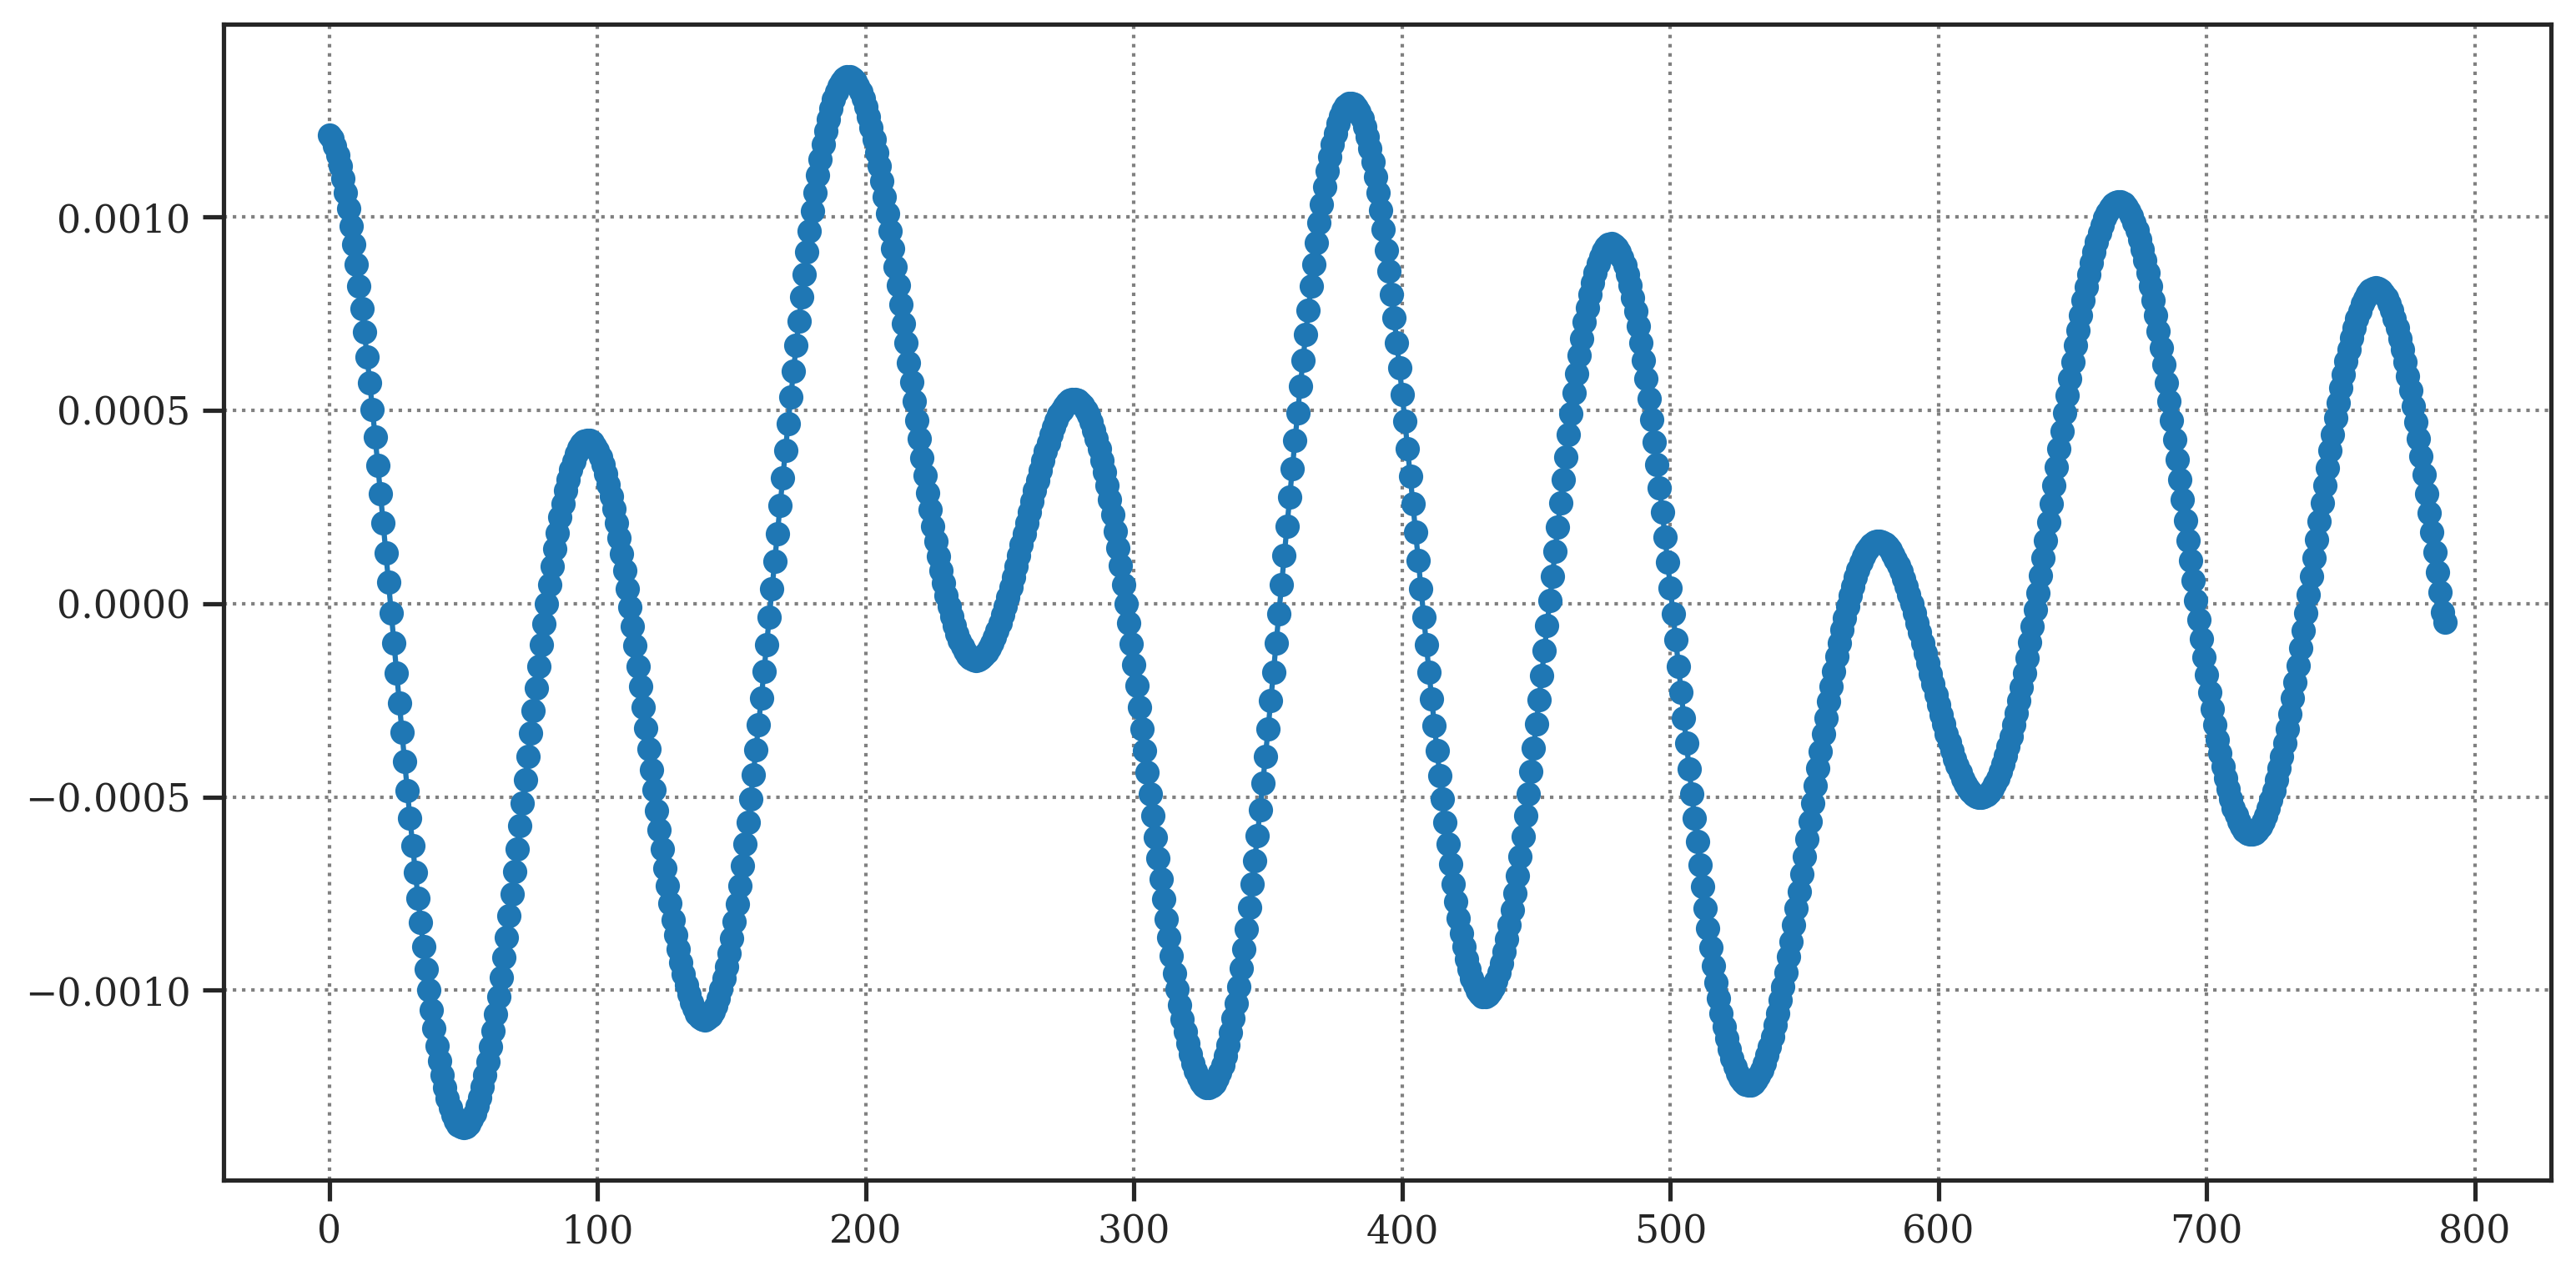

In [18]:
y_grad = np.gradient(y_mean)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_test, y_grad, 'o-')

## GP Regression with Periodic Kernel

In [19]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

x_tr = torch.tensor(x_test.numpy(), dtype=torch.double)
y_tr = torch.tensor(y_grad, dtype=torch.double)

if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

TypeError: type torch.cuda.DoubleTensor not available. Torch not compiled with CUDA enabled.

 Let's re-define the model. Now, we will only use a single periodic kernel with relatively smaller noise. The lengthscale parameter does not seem to matter too much, and I can use a 90-minute periodicity as a prior based on the results from the previous GP regression.

In [ ]:
class PeriodicGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(PeriodicGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.ScaleKernel(
            base_kernel = gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)

        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [ ]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Positive(),
    noise_prior=gpytorch.priors.UniformPrior(5e-5, 5e-2),
)
model = PeriodicGPModel(x_tr, y_tr, likelihood)

model.mean_module.register_prior(
    "mean_prior", gpytorch.priors.UniformPrior(-1, 1), "constant"
)
model.cov_module.register_prior(
    "outputscale_prior", gpytorch.priors.UniformPrior(1, 2), "outputscale"
)
model.cov_module.base_kernel.initialize(
    lengthscale = torch.tensor(15.),
    period_length = torch.tensor(95.)
)
model.cov_module.base_kernel.register_prior(
    "period_length_prior", gpytorch.priors.UniformPrior(60, 130), "period_length"
)

# model.cov_module.base_kernel.raw_lengthscale.requires_grad_(False)

model.double()
likelihood.double()

if device.type == "cuda":
    model = model.to(device)
    likelihood = likelihood.to(device)

In [ ]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:48} \t {param.item()}")
    
print(f"\n {model.cov_module.base_kernel}")

likelihood.noise_covar.raw_noise                 	 0.0
mean_module.constant                             	 0.0
cov_module.raw_outputscale                       	 0.0
cov_module.base_kernel.raw_lengthscale           	 14.999999694097633
cov_module.base_kernel.raw_period_length         	 95.0

 PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
  (period_length_prior): UniformPrior(low: 60.0, high: 130.0)
)


In [ ]:
num_samples = 700

def pyro_model(x, y):
    sampled_model = model.pyro_sample_from_prior()
    output = sampled_model.likelihood(sampled_model(x))

    pyro.sample("obs", output, obs=y)

    return y

nuts_kernel = pyro.infer.mcmc.NUTS(
    pyro_model
)

mcmc_run = pyro.infer.mcmc.MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=300
)
mcmc_run.run(x_tr, y_tr)

Sample: 100%|██████████| 1000/1000 [09:16,  1.80it/s, step size=1.31e-01, acc. prob=0.897]


In [ ]:
p = mcmc_run.get_samples()['cov_module.base_kernel.period_length_prior'].cpu()

In [ ]:
# Fit the periodicity distribution with KDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_grid = np.linspace(60, 130, 200)
y_data = np.ravel(p.numpy())

bw = 0.5    # Default bandwith for KDE
if True:
    # use grid search cross-validation to optimize the bandwidth
    params = {"bandwidth": np.linspace(.1, 10, 100)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(y_data[:, None])

    bw = grid.best_estimator_.bandwidth
    log_kde = grid.best_estimator_
else:
    # Place a safe bet for bandwidth
    log_kde = KernelDensity(bandwidth=bw).fit(y_data)

kde = np.exp(log_kde.score_samples(x_grid[:, None]))

The offset of the gaussian baseline is 0.005250368740041353
The center of the gaussian fit is 95.29716104765895
The sigma of the gaussian fit is 3.1821934107796186
The maximum intensity of the gaussian fit is 0.08348117577894021
The Amplitude of the gaussian fit is 0.07823080703889886
The FWHM of the gaussian fit is 7.493492687572062


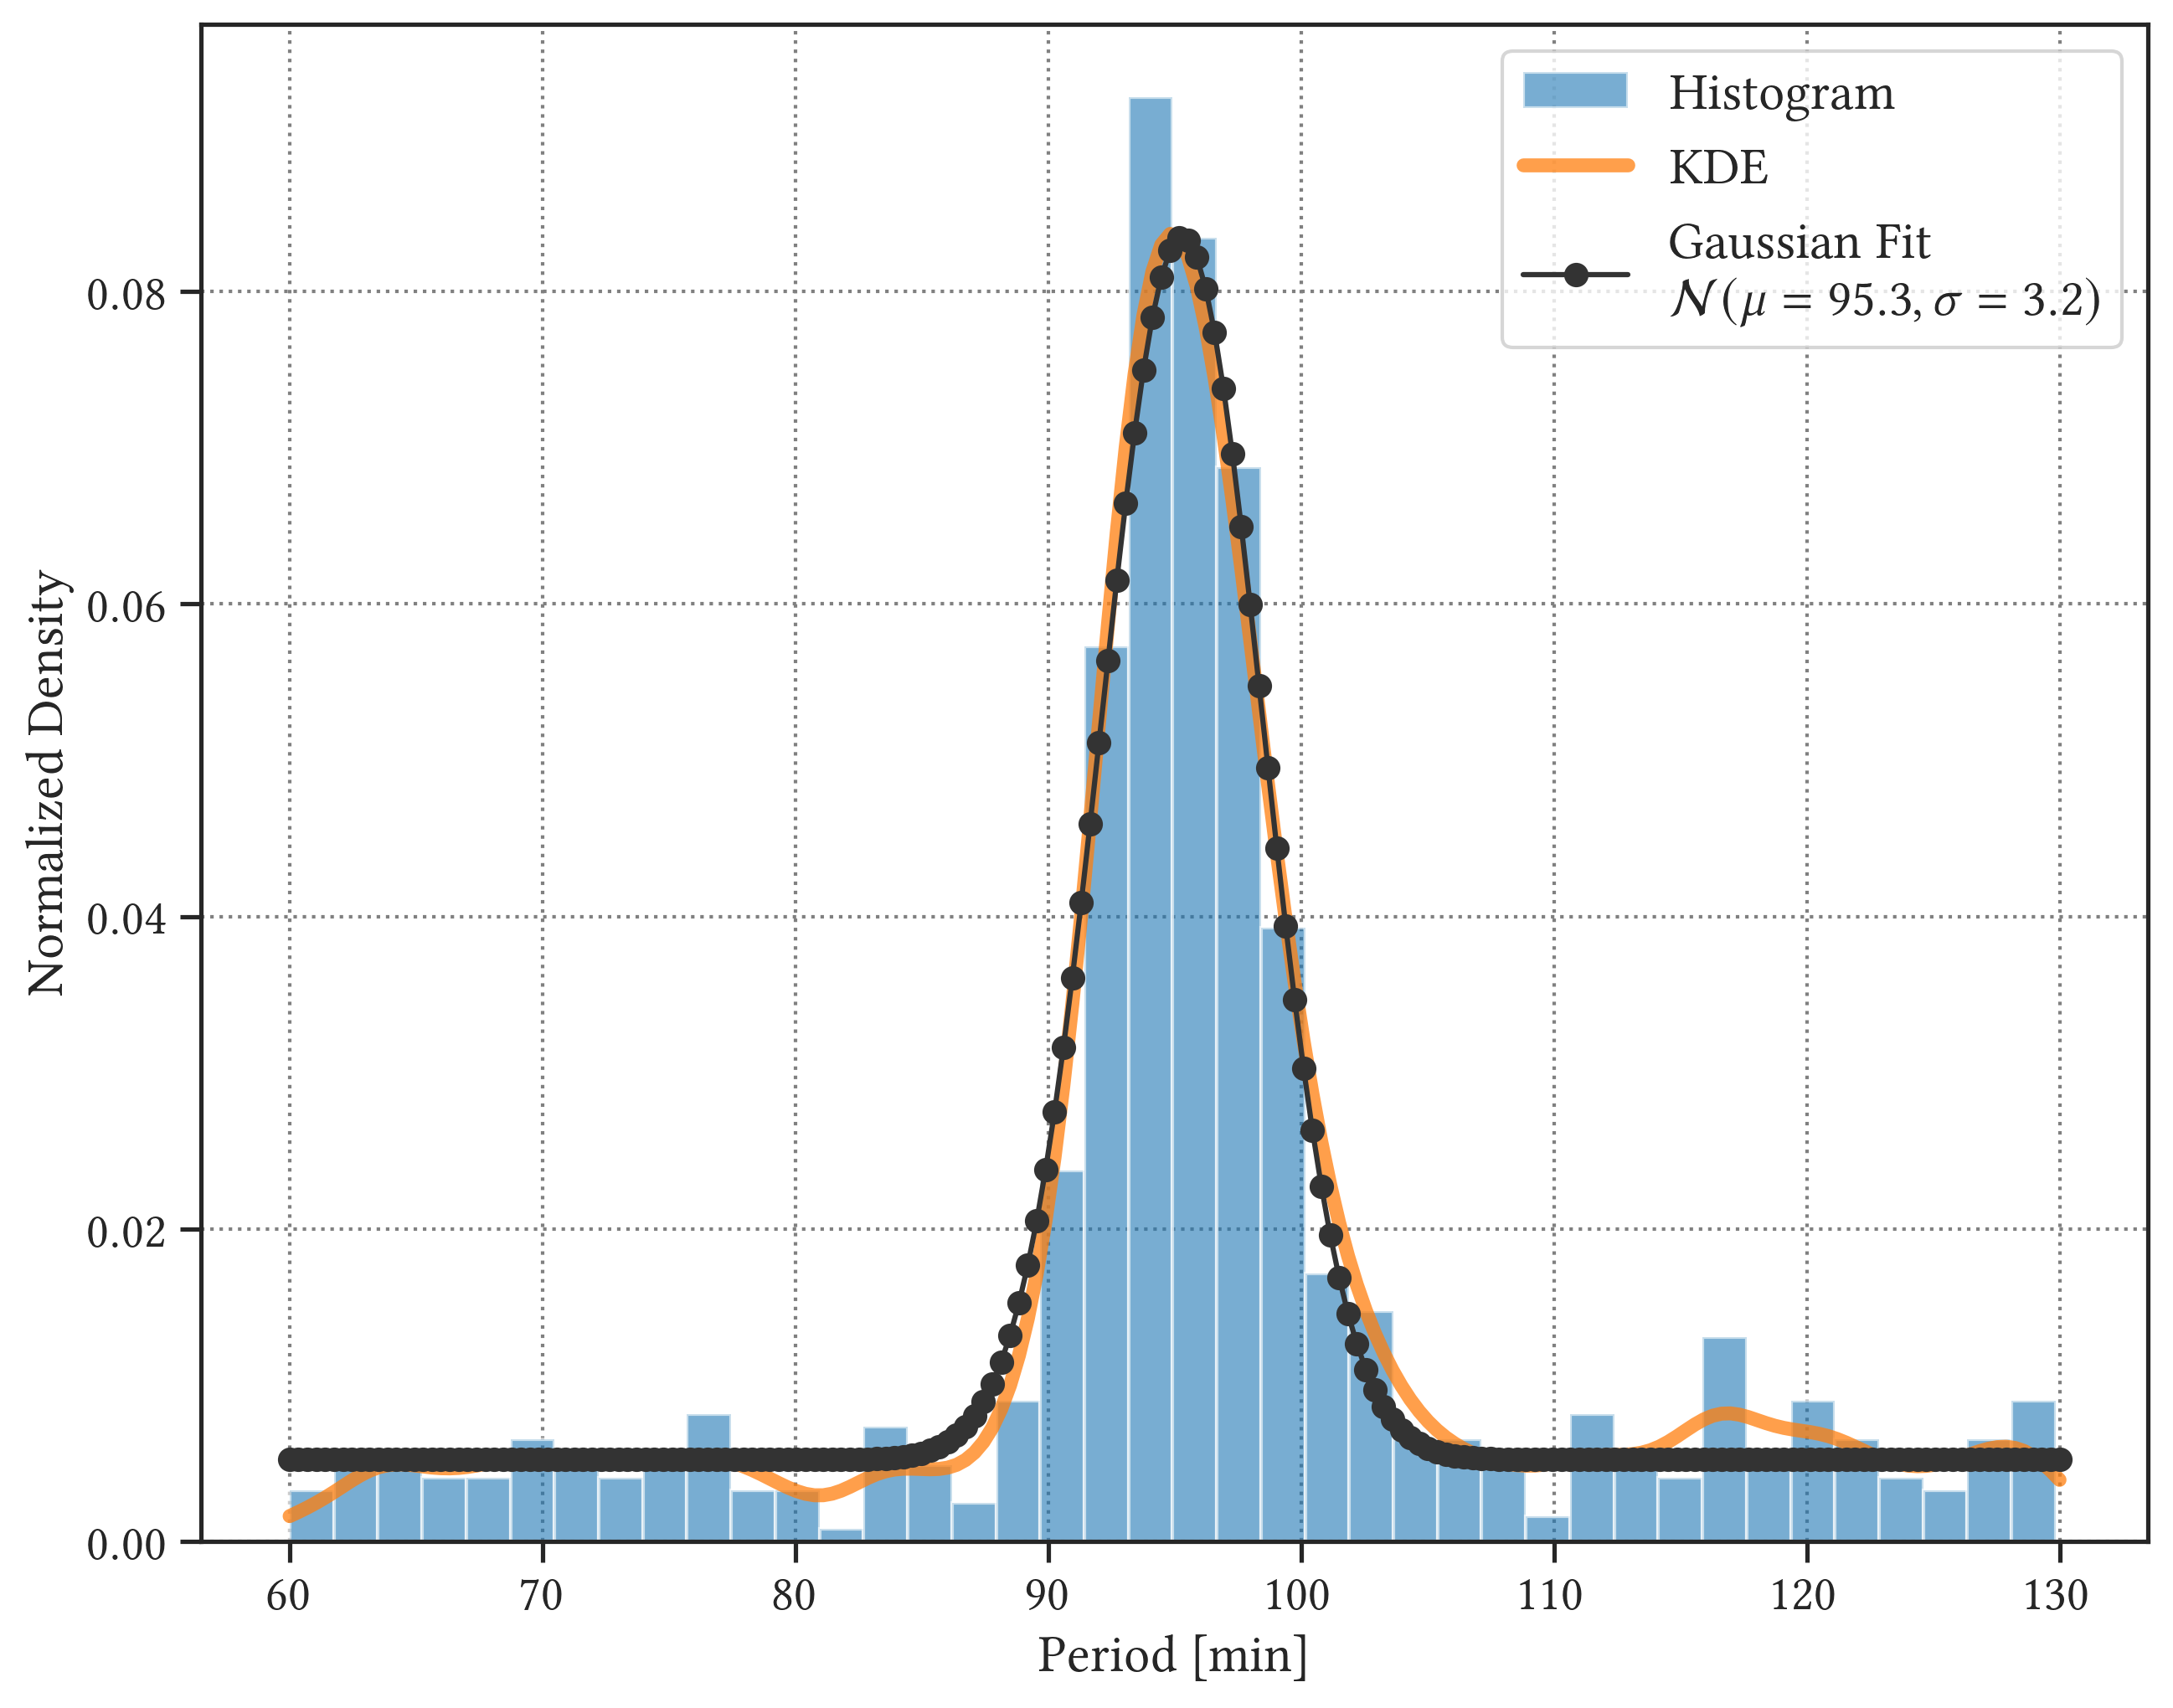

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)

from scipy import optimize


def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))


def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * np.abs(x - mean) ** 2) / sum(y))
    popt, _ = optimize.curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt


H, A, x0, sigma = gauss_fit(x_grid, kde)
FWHM = 2.35482 * sigma

print("The offset of the gaussian baseline is", H)
print("The center of the gaussian fit is", x0)
print("The sigma of the gaussian fit is", sigma)
print("The maximum intensity of the gaussian fit is", H + A)
print("The Amplitude of the gaussian fit is", A)
print("The FWHM of the gaussian fit is", FWHM)

ax.hist(np.ravel(p.numpy()), bins=40, alpha=0.6, density=True, label="Histogram")

ax.plot(x_grid, kde, "C1", alpha=0.75, lw=4, label="KDE")
ax.plot(
    x_grid,
    gauss(x_grid, *gauss_fit(x_grid, kde)),
    "o-",
    c="0.2",
    label=f"Gaussian Fit \n $\mathcal{{N}}(\mu = {x0:.1f}, \sigma = {sigma:.1f})$",
)

ax.legend(fontsize=15)

ax.set_xlabel("Period [min]", fontsize=15)
ax.set_ylabel("Normalized Density", fontsize=15)

ax.tick_params(axis="both", which="major", labelsize=14)


In [ ]:
# model.pyro_load_from_samples(mcmc_run.get_samples())

# model.eval()

# if device.type == 'cuda':
#     model = model.cpu()
#     likelihood = likelihood.cpu()

#     x_tr = x_tr.cpu()
#     y_tr = y_tr.cpu()
    
# x_test2 = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
# output = model(x_test2.cpu())

: 

: 

In [ ]:
# mcmc_run.summary()